## How to do it

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [27]:
iris = datasets.load_iris()
x_vals = np.array([x[0:3] for x in iris.data])
y_vals = np.array([x[3] for x in iris.data])

In [28]:
seed = 3
tf.random.set_seed(seed)
np.random.seed(seed)

In [29]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))
batch_size = 50
x_data = tf.keras.Input(dtype=tf.float32, shape=(3,))

In [30]:
hidden_layer_nodes = 5
a1 = tf.Variable(tf.random.normal(shape=[3, hidden_layer_nodes], seed=seed))
b1 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes], seed=seed))
a2 = tf.Variable(tf.random.normal(shape=[hidden_layer_nodes, 1], seed=seed))
b2 = tf.Variable(tf.random.normal(shape=[1], seed=seed))

In [31]:
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a1), b1)))

final_output = tf.keras.layers.Lambda(lambda x: tf.nn.relu(tf.add(tf.matmul(x, a2), b2)))

hideen_layer = hidden_output(x_data)
output = final_output(hideen_layer)

model = tf.keras.Model(inputs=x_data, outputs = output, name='1layer_neural_network')

The following Variables were used a Lambda layer's call (lambda_10), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(3, 5) dtype=float32>
  <tf.Variable 'Variable:0' shape=(5,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_11), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(5, 1) dtype=float32>
  <tf.Variable 'Variable:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [32]:
optimizer = tf.keras.optimizers.SGD(0.005)

In [33]:
# First we initialize the loss vectors for storage
loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    
    # Open a gradient tape
    with tf.GradientTape(persistent=True) as tape:
        
        # Forward pass.
        output = model(rand_x)
        
        # Apply loss function (MSE)
        loss = tf.reduce_mean(tf.square(rand_y - output))
        loss_vec.append(np.sqrt(loss))
        
    # Get gradients of loss with reference to the variables to adjust
    gradients_a1 = tape.gradient(loss, a1)
    gradients_b1 = tape.gradient(loss, b1)
    gradients_a2 = tape.gradient(loss, a2)
    gradients_b2 = tape.gradient(loss, b2)
    
    # Update the variables of the model
    optimizer.apply_gradients(zip([gradients_a1, gradients_b1, gradients_a2, gradients_b2], [a1, b1, a2, b2]))
    
    # Forward pass
    output_test = model(x_vals_test)
    # Apply loss function (MSE) on test
    loss_test = tf.reduce_mean(tf.square(np.transpose([y_vals_test]) - output_test))
    test_loss.append(np.sqrt(loss_test))
    
    if (i+1)%50==0:
        print(f'Generation: {i+1}. Loss = {np.mean(loss)}')

Generation: 50. Loss = 0.6273956298828125
Generation: 100. Loss = 0.15347698330879211
Generation: 150. Loss = 0.1543102264404297
Generation: 200. Loss = 0.11715933680534363
Generation: 250. Loss = 0.12236560881137848
Generation: 300. Loss = 0.12134756147861481
Generation: 350. Loss = 0.07258755713701248
Generation: 400. Loss = 0.14590775966644287
Generation: 450. Loss = 0.1407577395439148
Generation: 500. Loss = 0.13127386569976807


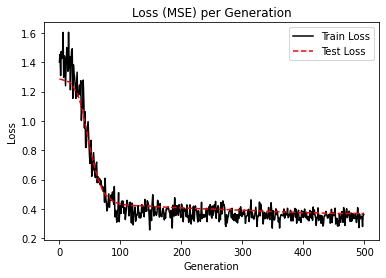

In [34]:
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()